In [102]:
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd

pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from tqdm import tqdm
from sklearn import metrics
from statsmodels.tsa.stattools import pacf, acf
import statsmodels.api as sm
from prophet import Prophet
from tqdm import tqdm_notebook

In [24]:
forecasts = {}
test_errors = {}

In [136]:
data = pd.read_csv("PJME_hourly.csv", parse_dates=['Datetime']).sort_values(by = "Datetime")

def split_data(data, split_date):
    return data[data['Datetime'] <= split_date].copy(), \
           data[data['Datetime'] >  split_date].copy()

def limit(data, frm, to):
    return data[(data['Datetime']>=frm)&(data['Datetime']<to)]

train, test = split_data(data, '01-Jul-2002')

train = limit(data, '03-01-2011', '04-01-2011')
test  = limit(data, '04-01-2011', '05-01-2011')

In [137]:
df = pd.concat([train, test])
#df.iloc[len(train):, 1] = np.nan

In [138]:
df['hour'] = df['Datetime'].dt.hour
df['day_of_month'] = df['Datetime'].dt.days_in_month
df['day_of_week'] = df['Datetime'].dt.day_of_week

<Axes: xlabel='Datetime'>

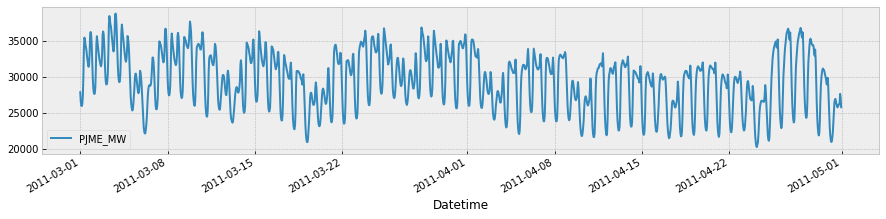

In [139]:
df.plot(y='PJME_MW', x='Datetime', figsize = (15, 3))

In [140]:
dates = df['Datetime'].unique()
hours = np.arange(1, len(dates)+1)
hours = pd.DataFrame({"Datetime":dates, "date_index":hours})
df = df.merge(hours, on="Datetime", how="left")

In [141]:
df = df.rename(columns = {'Datetime': 'date'})

In [183]:
class my_model:

    def __init__(self, df, target, group_features = [], categorical_features = [], scoring_metric = metrics.mean_squared_error):
        self.df = df
        self.target = target
        self.group_features = group_features
        self.categorical_features = categorical_features
        self.scoring_metric = scoring_metric
        self.time_delta = pd.Timedelta(self.df['date'].unique()[1] - self.df['date'].unique()[0])
        
    def create_seasonality(self, data, fs = 365):
        
        ret = pd.DataFrame()
        
        fs = pd.Timedelta(365, 'd')/self.time_delta
        
        freqencies, spectrum = periodogram(
            data[data[self.target].notna()].groupby('date')[self.target].mean(),
            fs=fs,
            detrend='linear',
            window="boxcar",
            scaling='spectrum',
        )

        Seasonality = np.round(fs/freqencies[spectrum > spectrum.max()/5], 2)
        
        for s in Seasonality:
            ret[f'sin_{s}'] = np.sin(data['date_index'] * (2*np.pi / s))
            ret[f'cos_{s}'] = np.cos(data['date_index'] * (2*np.pi / s))

        return pd.concat([data, ret], axis = 1)
    
    def create_lags(self, data, lags = True):
    
        ret = pd.DataFrame()
        
        if lags == True:
            average_sales = data[data[self.target].notna()].groupby('date')[self.target].mean()
            alpha=0.05
            method="ywm"
            nlags = len(average_sales)//2-1
            lags, thresh = pacf(average_sales, nlags=nlags, alpha=alpha, method=method)
            lags = np.where((lags/3 > thresh[:, 1] - lags) | (lags/3 < thresh[:, 0] - lags))[0][1:]

        if len(self.group_features):
            for lag in lags:                                                                                                                          
                ret[f'lag_{lag}'] = data.groupby(self.group_features)[self.target].transform(lambda x: x.shift(lag))
                
        elif len(self.group_features) == 0:
            for lag in lags:
                ret[f'lag_{lag}'] = data[self.target].shift(lag)
        
        ret = pd.concat([data, ret], axis = 1)
        nan_head = ret[ret.index == ret.index[0] + (lags[-1] * self.time_delta)].index[0]
        ret = ret[nan_head:]

        return ret, lags

    def train_valid_split(self, data, split = 0.7):

        n = len(data)

        split_date = data.index.unique()[int(n*split)]

        X_valid = data.dropna()
        
        y_valid = X_valid.loc[split_date:, self.target].copy()
        X_valid.loc[split_date:, self.target] = np.nan

        return X_valid, y_valid

    def validate(self, model, seasonality = False, lag = False, by = None, plot = False):
        
        model_name = str(model).split(".")[-1].split("'")[0]
        
        if by != None and (by not in self.group_features):
            raise f"by = {by} not in {self.group_features}"
            
        if len(self.group_features) == 0:
            df_valid , y_valid = self.train_valid_split(self.df[self.df[self.target].notna()].set_index('date'))
            
            if seasonality:
                df_valid = self.create_seasonality(df_valid)
                
            if lag == False:
                
                df_valid = pd.get_dummies(df_valid, columns = self.categorical_features)
                
                X_train = df_valid[df_valid[self.target].notna()].drop(columns = self.target)
                y_train = df_valid[df_valid[self.target].notna()][self.target]
                
                X_valid = df_valid[df_valid[self.target].isna()].drop(columns = self.target)
                
                model_ = model()
                model_.fit(X_train.drop(columns = 'Id'), y_train)
                
                y_pred = model_.predict(X_valid.drop(columns = 'Id'))
                y_pred[y_pred < 0] = 0
                y_pred = pd.Series(y_pred, index = X_valid.index)
                y_pred_w_id = pd.DataFrame({'Id': X_valid['Id'], self.target: y_pred}, index = y_pred.index)
                
                y_train_pred = model_.predict(X_train.drop(columns = 'Id'))
                y_train_pred[y_train_pred < 0] = 0
                training_score = self.scoring_metric(y_train, y_train_pred)
                test_score = self.scoring_metric(y_valid, y_pred)
                
                scores = pd.DataFrame({model_name: [training_score, test_score]}, index = ['Training score', 'Test score']).T
                display(scores)
                
                if plot == True:
                    ax = y_train.plot(figsize = (15, 3))
                    y_valid.plot(ax = ax, color = 'tab:blue', alpha = 0.5)
                    y_pred.plot(ax = ax, color = 'tab:orange')
                    ax.set_xlabel('date')
                    ax.set_ylabel(self.target)
                    plt.tight_layout()
                    plt.show()
                
                return y_pred_w_id, scores
                
            if lag != False:
                
                df_valid, lags = self.create_lags(df_valid, lag)
                df_valid = pd.get_dummies(df_valid, columns = self.categorical_features)
                
                X_train = df_valid[df_valid[self.target].notna()].drop(columns = self.target)
                y_train = df_valid[df_valid[self.target].notna()][self.target]
                
                model_ = model()
                model_.fit(X_train.drop(columns = 'Id'), y_train)
                
                y_train_pred = model_.predict(X_train.drop(columns = 'Id'))
                y_train_pred[y_train_pred < 0] = 0
                training_score = self.scoring_metric(y_train, y_train_pred)
                
                forecast_index = df_valid[df_valid[self.target].isna()].index
                for i in tqdm_notebook(range(len(forecast_index))):
                    
                    future_index = df_valid[df_valid[self.target].isna()].index[0]
                    future_X = df_valid.loc[future_index:future_index].drop(columns = self.target)
                    
                    future_1 = model_.predict(future_X.drop(columns = 'Id'))[0]
                    
                    df_valid.loc[future_index, self.target] = future_1
                    for lag in lags:
                        df_valid.loc[future_index + (lag * self.time_delta), f'lag_{lag}'] = future_1
                        
                y_pred_w_id = df_valid.loc[forecast_index, ['Id', self.target]].copy()
                y_pred_w_id.loc[y_pred_w_id[self.target] < 0, self.target] = 0
                
                y_pred = y_pred_w_id[self.target]
                
                test_score = self.scoring_metric(y_valid, y_pred)
                
                scores = pd.DataFrame({model_name: [training_score, test_score]}, index = ['Training score', 'Test score']).T
                display(scores)
                
                if plot == True:
                    ax = y_train.plot(figsize = (15, 3))
                    y_valid.plot(ax = ax, color = 'tab:blue', alpha = 0.5)
                    y_pred.plot(ax = ax, color = 'tab:orange')
                    ax.set_xlabel('date')
                    ax.set_ylabel(self.target)
                    plt.tight_layout()
                    plt.show()
                
                return y_pred, scores    

In [192]:
def root_mean_squared_log_error(y_true, y_pred):
    return metrics.mean_squared_log_error(y_true, y_pred)**(1/2)


model = my_model(df, 'PJME_MW', categorical_features = ['day_of_week', 'hour'],
                scoring_metric = metrics.mean_absolute_percentage_error)

,Training score,Test score
XGBRegressor,0.002389,0.054592


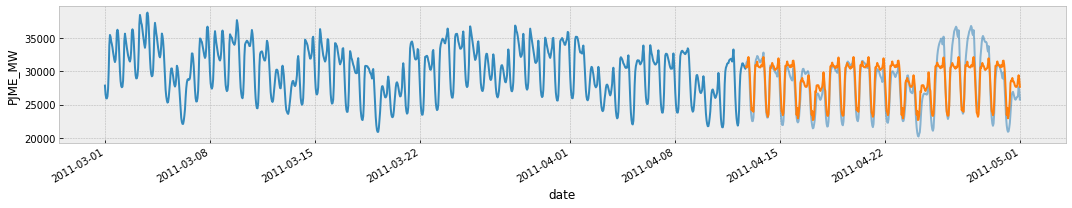

In [193]:
pred = model.validate(XGBRegressor, plot = True)

  0%|          | 0/439 [00:00<?, ?it/s]

,Training score,Test score
XGBRegressor,0.000505,0.158561


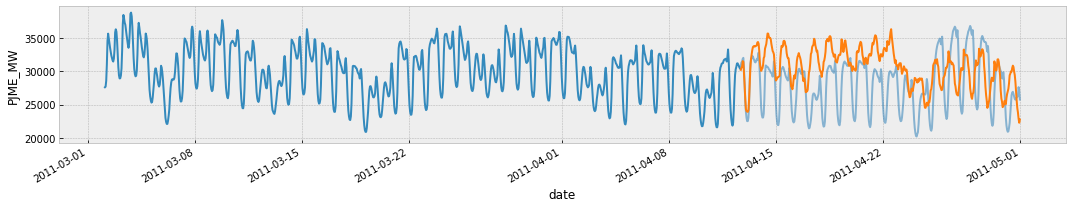

In [195]:
pred = model.validate(XGBRegressor, seasonality = True, lag = True, plot = True)

In [191]:
df['Id'] = 0